Same as the Proof of Concept but running against data from Ethan

In [15]:
import numpy as np
from scipy import ndimage
import pywt
import pandas as pd
from glob import glob
from os import path

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [17]:
data_dir = 'gaia_data/' #unzipped "v2" 

In [18]:
dwarfs = sorted(glob(path.join(data_dir, '*dwarf.txt')))
rests = sorted(glob(path.join(data_dir, '*rest.txt')))

In [19]:
def make_field_image(full_field, n_pos= 101, n_vel=101):
    pos_min, pos_max =  np.min(full_field, axis =0)[:2], np.max(full_field, axis =0)[:2]
    ra_min, ra_max = pos_min[0]-0.1, pos_max[0]+0.1
    dec_min, dec_max = pos_min[1]-0.1, pos_max[1]+0.1

    vra_min, vra_max = -20, 20
    vdec_min, vdec_max =-20, 20

    field_image, _ = np.histogramdd(full_field,\
                            bins=(np.linspace(ra_min, ra_max, n_pos),
                                  np.linspace(dec_min, dec_max, n_pos), 
                                  np.linspace(vra_min, vra_max, n_vel),
                                  np.linspace(vdec_min, vdec_max, n_vel) ) )
    
    return field_image

In [20]:
def convert_max_to_orig_coord(max_pos, wavelet_size, orig_field):
    n_pos, n_vel = 101,101 #lazy
    
    pos_min, pos_max =  np.min(orig_field, axis =0)[:2], np.max(orig_field, axis =0)[:]
    ra_min, ra_max = pos_min[0], pos_max[0]
    dec_min, dec_max = pos_min[1], pos_max[1]
    vra_min, vra_max = -20, 20
    vdec_min, vdec_max =-20, 20

    upscaled_pos = max_pos*n_pos*1.0/wavelet_size #TODO diff bins in vel and pos
    orig_coord = np.zeros_like(max_pos)
    orig_coord[0] = (ra_max-ra_min)*upscaled_pos[0]/n_pos + ra_min
    orig_coord[1] = (dec_max-dec_min)*upscaled_pos[1]/n_pos+dec_min
    orig_coord[2] = (vra_max-vra_min)*upscaled_pos[2]/n_vel + vra_min
    orig_coord[3] = (vdec_max-vdec_min)*upscaled_pos[3]/n_vel + vdec_min
    return orig_coord

In [21]:
def find_max(im, orig_field):
    max_pos = ndimage.measurements.maximum_position(np.abs(im))
    return convert_max_to_orig_coord(np.array(max_pos), im.shape[0], orig_field)

In [22]:
def plot(im, orig_field):
    #max_pos = ndimage.measurements.maximum_position(np.abs(im))
    plt.subplot(121)
    plt.imshow(im.sum(axis = (2,3)).T)
    #plt.scatter(max_pos[0], max_pos[1], marker = 'x')
    plt.subplot(122)
    plt.imshow(im.sum(axis = (0,1)).T)
    #plt.scatter(max_pos[2], max_pos[3], marker = 'x')

    plt.show()

In [23]:
def filter_layer(im, l =  [1.0, 2.5, 5.0, 10.0]):
    " return im filtered by the l filters"
    
    return np.stack([ndimage.filters.gaussian_filter(im, l) for l in l])

In [24]:
def slice_and_stack(outputs): 
    # lazily slice off edges of images so they have the same size
    min_size = min([o.shape[1] for o in outputs])
    
    sas_output = []
    
    for o in outputs:
        size = o.shape[1]
        if size == min_size:
            sas_output.append(o)
        else:
            gap = size - min_size
            odd_gap = gap%2
            g_2 = gap/2
            sas_output.append(o[:,g_2:-(g_2+odd_gap), 
                                  g_2:-(g_2+odd_gap),
                                  g_2:-(g_2+odd_gap),
                                  g_2:-(g_2+odd_gap)])

    return np.vstack(sas_output)

In [25]:
def wavelet_layer(im, wavlets = ['bior1.1', 'bior2.2', 'bior3.3']):#, 'bior4.4', 'bior5.5']):
    all_outputs = []
    for wv in wavlets:
        wv_outputs = []
        for i in im:
            LLLL = pywt.dwtn(i, wv)['aaaa']
            #all_outputs.append(np.stack([LL, LH, HL, HH]))
            wv_outputs.append(LLLL)
        all_outputs.append(np.stack(wv_outputs))
            
    return slice_and_stack(all_outputs)

In [26]:
def find_ufdg(im):
    filtered_im = filter_layer(im)
    wv_im = wavelet_layer(filtered_im)
    max_arr = np.stack([find_max(wi, full_field) for wi in wv_im])
    return filtered_im, wv_im, max_arr

gaia_data/dgaia_eri_ii_dwarf.txt


/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


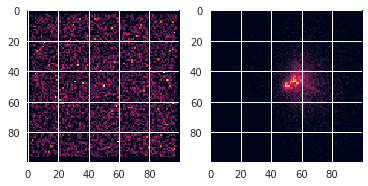

[ 55.83333333 -43.16666667   1.16666667  -0.16666667] [0.5527708  0.372678   1.21335165 0.372678  ]


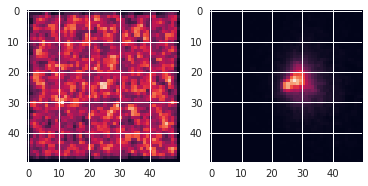

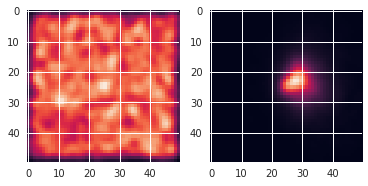

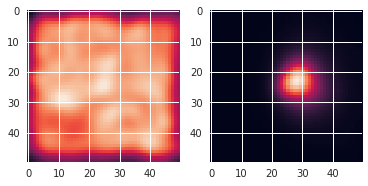

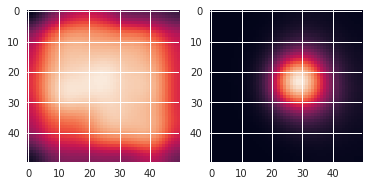

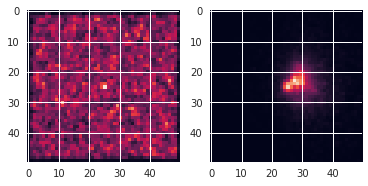

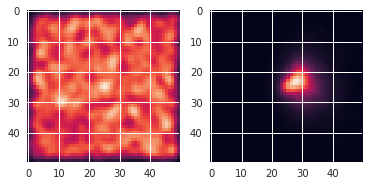

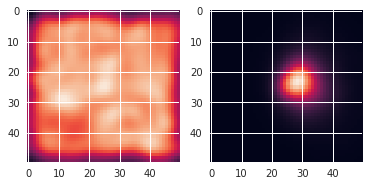

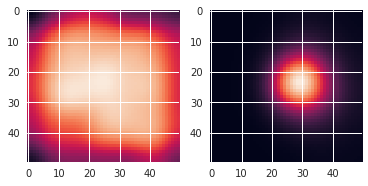

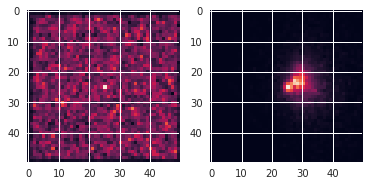

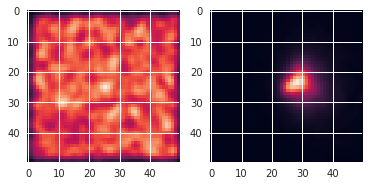

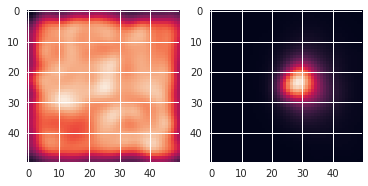

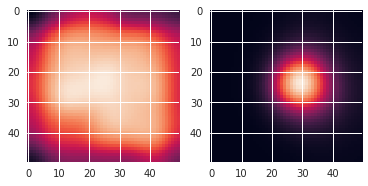

--------------------
gaia_data/dgaia_eri_iii_dwarf.txt


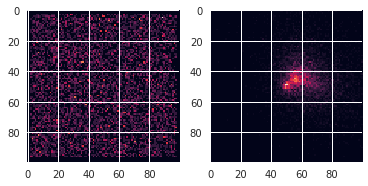

[ 34.83333333 -52.25         1.91666667  -1.33333333] [0.79930525 0.59511904 0.8620067  0.62360956]


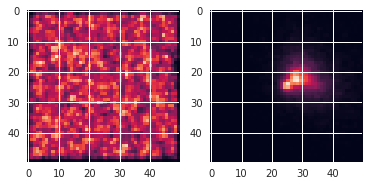

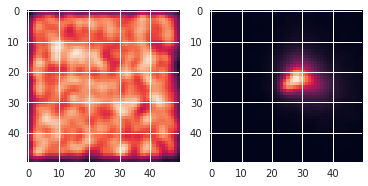

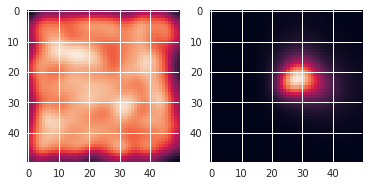

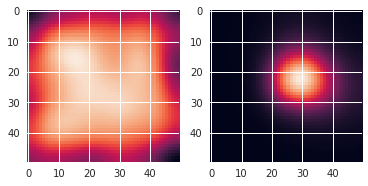

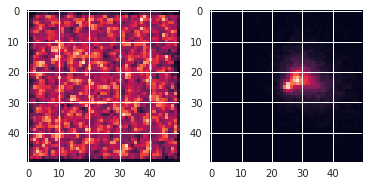

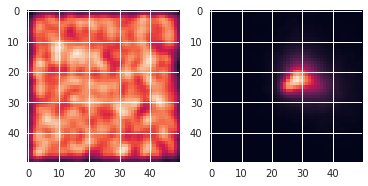

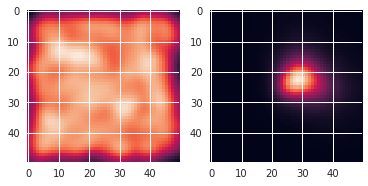

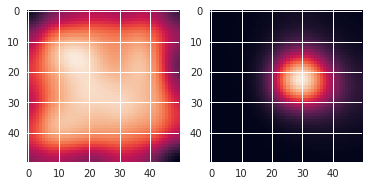

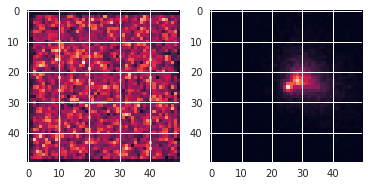

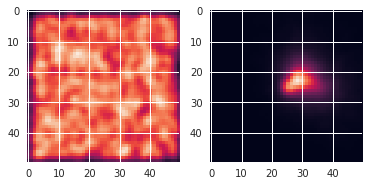

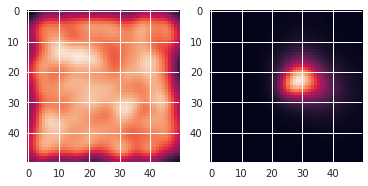

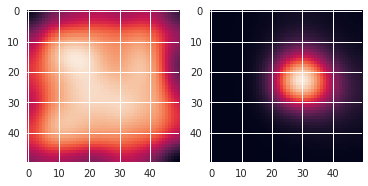

--------------------
gaia_data/dgaia_hor_i_dwarf.txt


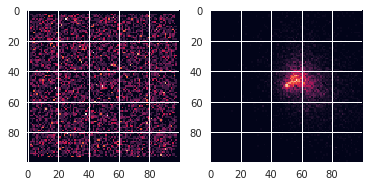

[ 43.         -54.           1.25        -0.41666667] [0.         0.         1.23322072 0.49300665]


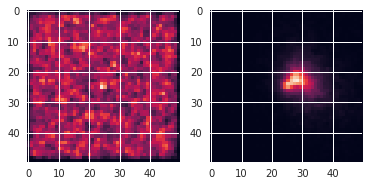

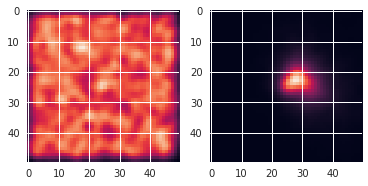

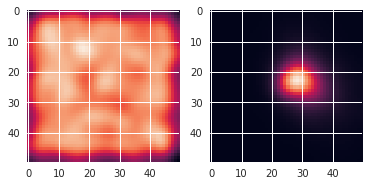

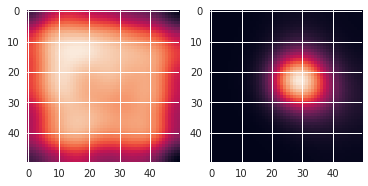

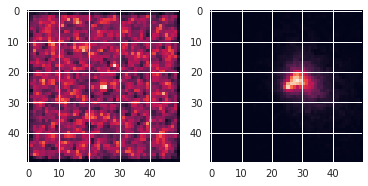

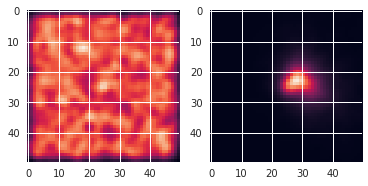

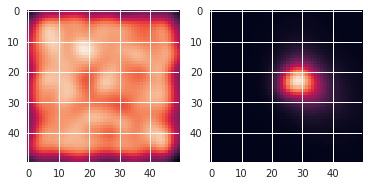

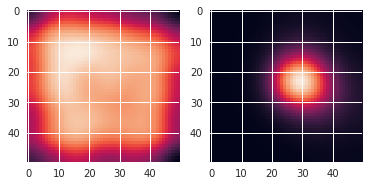

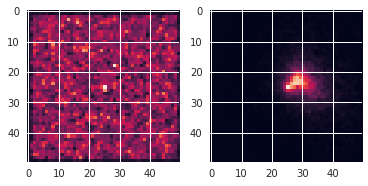

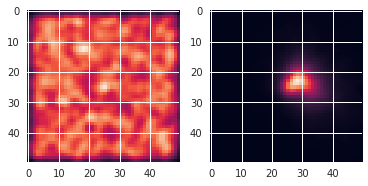

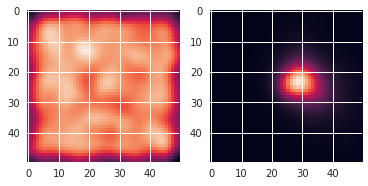

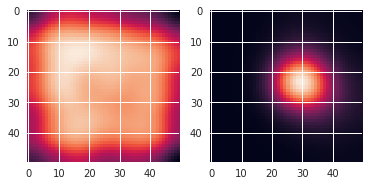

--------------------
gaia_data/dgaia_phe_ii_dwarf.txt


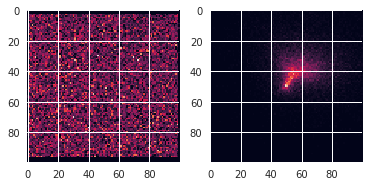

[352.16666667 -54.           1.58333333  -3.41666667] [1.4043583  0.81649658 2.43099202 0.9537936 ]


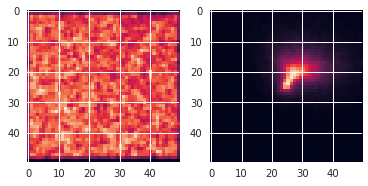

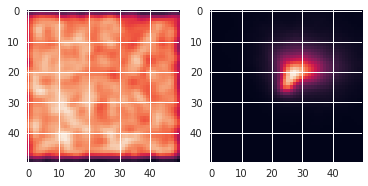

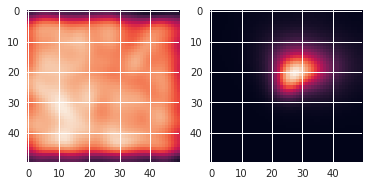

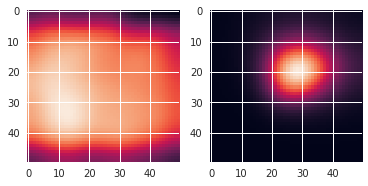

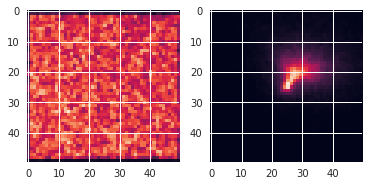

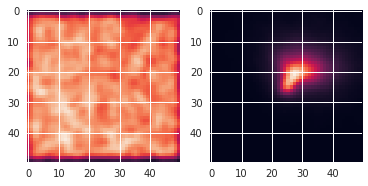

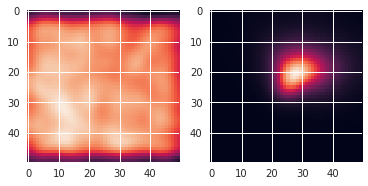

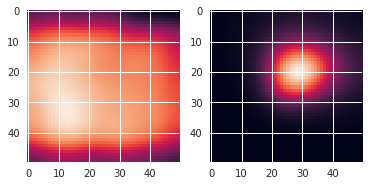

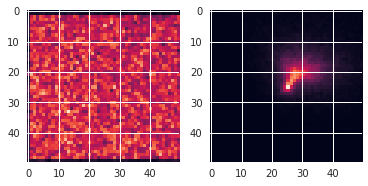

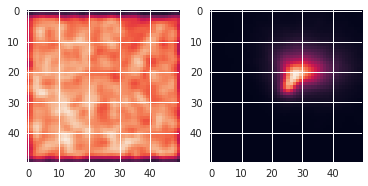

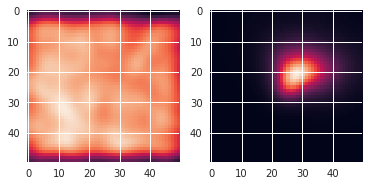

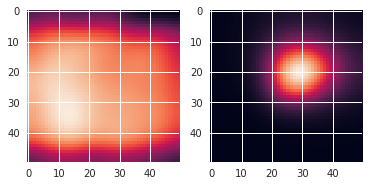

--------------------
gaia_data/dgaia_pic_i_dwarf.txt


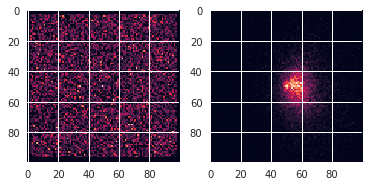

[ 71.41666667 -50.08333333   1.91666667   0.        ] [1.18731724 0.64009548 0.7592028  1.41421356]


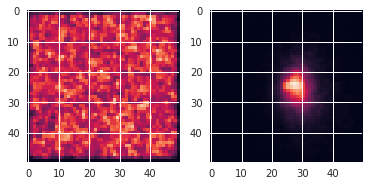

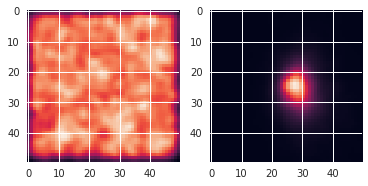

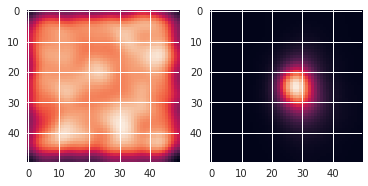

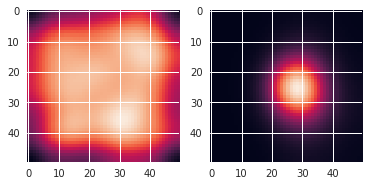

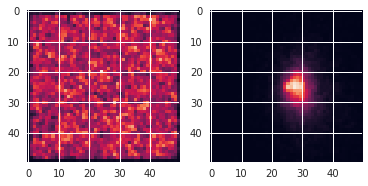

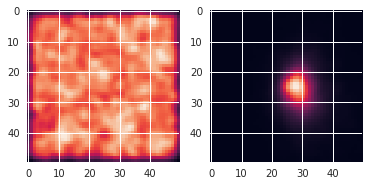

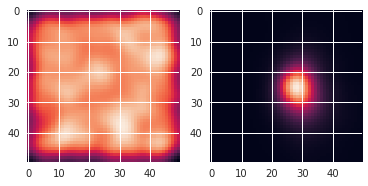

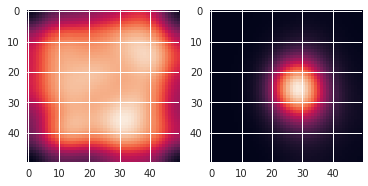

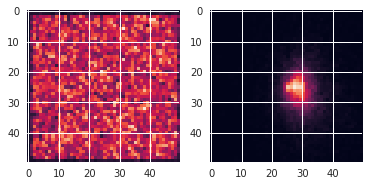

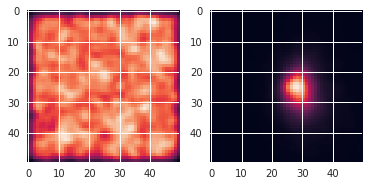

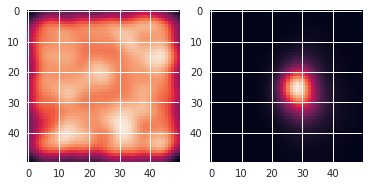

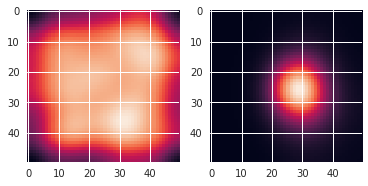

--------------------
gaia_data/dgaia_ret_ii_dwarf.txt


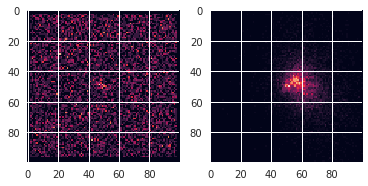

[ 53.         -54.           2.          -0.58333333] [0.         0.         0.57735027 0.49300665]


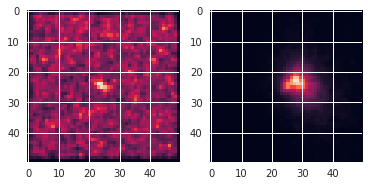

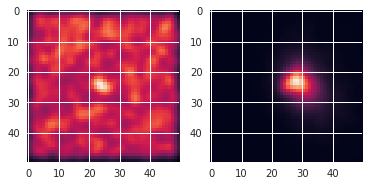

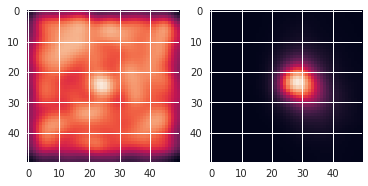

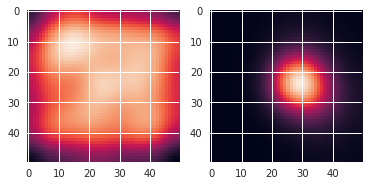

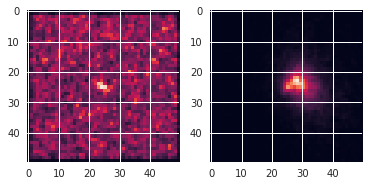

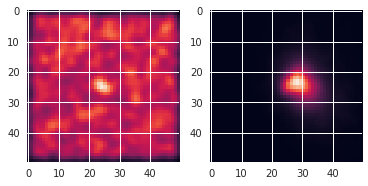

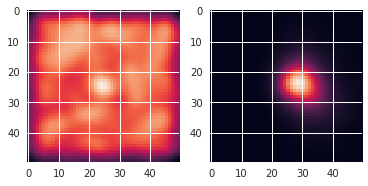

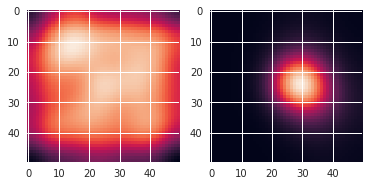

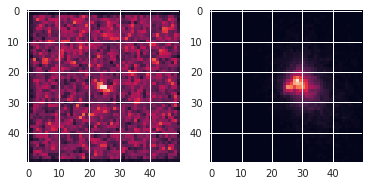

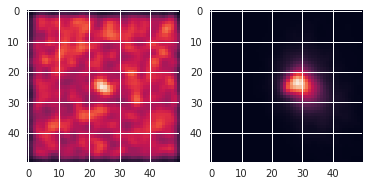

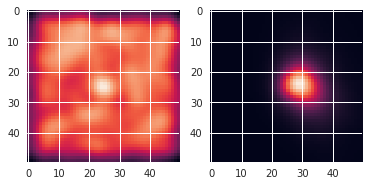

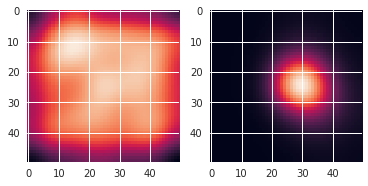

--------------------
gaia_data/dgaia_tuc_ii_dwarf.txt


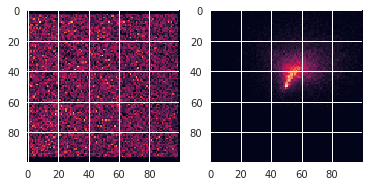

[339.41666667 -57.83333333   1.41666667  -3.41666667] [1.44096804 0.9860133  0.9537936  0.7592028 ]


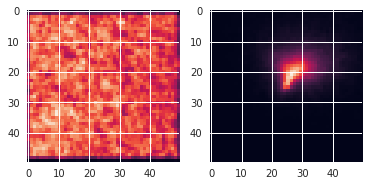

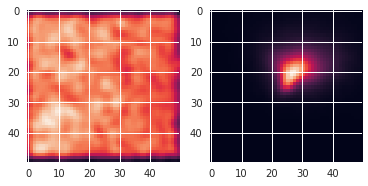

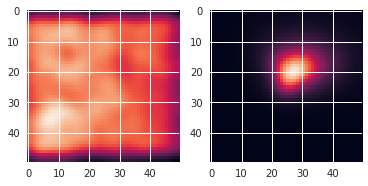

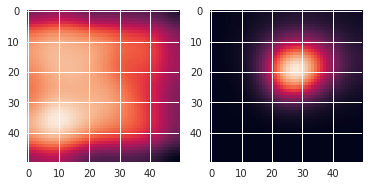

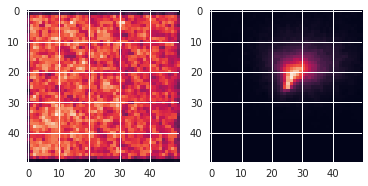

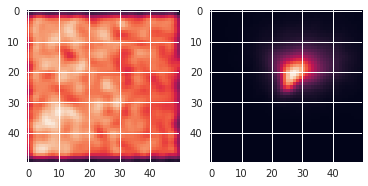

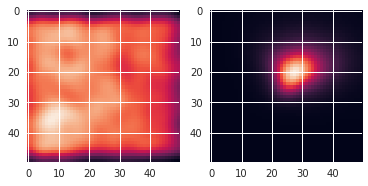

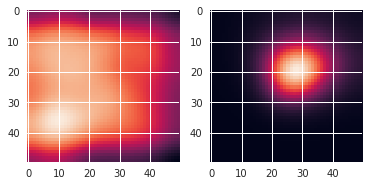

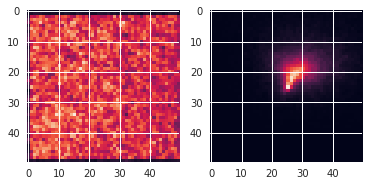

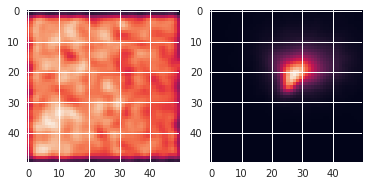

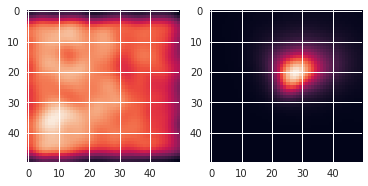

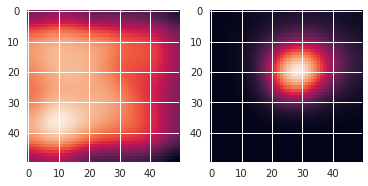

--------------------


In [27]:
for d_fname, r_fname in zip(dwarfs, rests):
    #if 'ret' not in d_fname:
    #   continue
    print d_fname
    d_data = pd.read_csv(d_fname)
    r_data = pd.read_csv(r_fname)
    
    d_field = np.c_[d_data['ra'].as_matrix(), d_data['dec'].as_matrix(), d_data['pmra'].as_matrix(), d_data['pmdec'].as_matrix()]
    r_field = np.c_[r_data['ra'].as_matrix(), r_data['dec'].as_matrix(), r_data['pmra'].as_matrix(), r_data['pmdec'].as_matrix()]
    full_field = np.vstack([d_field, r_field])
    full_field = full_field[np.all(~np.isnan(full_field), axis = 1)]
    #plt.scatter(full_field[:,0], full_field[:,1], alpha = 0.1)
    #plt.show()
    #plt.scatter(full_field[:,2], full_field[:,3], alpha = 0.1, color = 'g')
    #plt.show()
    field_image = make_field_image(full_field)
    plot(field_image, full_field)
    #filtered_im = filter_layer(field_image)
    _, final_im, max_coords = find_ufdg(field_image)

    print np.mean(max_coords, axis = 0), np.std(max_coords, axis = 0)
    for fi in final_im:
        plot(fi, full_field)
        
    print '-'*20
    